<a href="https://colab.research.google.com/github/thehimalayanleo/Private-Machine-Learning/blob/master/Fed_Averaging_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
from torch.utils.data import DataLoader, Dataset

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc = nn.Linear(1024, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        #x = x.view(-1, 784)
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 1024)
        #print(x.shape)
        x = F.relu(self.fc(x))
        #print(x.shape)
        return F.log_softmax(x, dim=1)

In [88]:
num_epochs = 10
lr = 0.01
batch_size = 64
batch_size_test = 1000
log_interval = 10
use_gpu = 0
device = torch.device('cuda:{}'.format(use_gpu) if torch.cuda.is_available() and use_gpu != -1 else 'cpu')

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [0]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

In [0]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=lr)

In [0]:
def test():
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = net(data)
      #print(target.shape)
      #print(output.shape)
      test_loss+=F.nll_loss(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred.shape)
      correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss/=len(test_loader.dataset)
  test_losses.append(test_loss)
  print('Test Set:  Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(test_loader.dataset),
                                                                                            100.*correct/len(test_loader.dataset)))

In [0]:
## Splitting dataset using indices

class DatasetSplit(Dataset): 
  def __init__(self, dataset, indices):
    self.dataset = dataset
    self.indices = list(indices)

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, item):
    image, label = self.dataset[self.indices[item]]
    return image, label

In [0]:
class LocalUpdate:
  def __init__(self, dataset=None, indices=None):
    #self.args = args
    self.train_loader = DataLoader(DatasetSplit(dataset, indices), batch_size=batch_size, shuffle=True)
  
  def train(self, net):
    #net = Net()
    epoch_losses = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.5)
    net.train()
    for iters in range(num_epochs):
      batch_loss = []
      for batch_indx, (data, target) in enumerate(self.train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    
        if batch_indx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(iters, batch_indx*len(data), len(self.train_loader.dataset), 
                                                                      100.*batch_indx/len(self.train_loader), loss.item()))
        batch_loss.append(loss.item())
      epoch_losses.append(sum(batch_loss)/len(batch_loss))
    return net.state_dict(), sum(epoch_losses)/len(epoch_losses)

In [0]:
def iid_dataset(dataset, num_users):
  dict_users = {}
  all_indices = [indx for indx in range(len(dataset))]
  num_items = int(len(dataset)/num_users)
  for user in range(num_users):
    dict_users[user] = set(np.random.choice(all_indices, num_items, replace=False))
    all_indices = list(set(all_indices)-dict_users[user])
  return dict_users

In [0]:
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))]))

num_users = 10
dict_users_mnist_iid = iid_dataset(dataset_train, num_users)

In [0]:
## Store global weights

global_net = Net().to(device)
global_weight = global_net.state_dict()


In [96]:
frac = 0.1
loss_training = []
for iter in range(num_epochs):
  local_weights, local_loss = [], []
  users_max = max(int(frac*num_users), 1)
  user_indices = np.random.choice(range(num_users), users_max, replace=False)
  for indx in user_indices:
    local_update = LocalUpdate(dataset=dataset_train, indices=dict_users_mnist_iid[indx])
    weight, loss = local_update.train(net=copy.deepcopy(global_net).to(device))
    local_weights.append(copy.deepcopy(weight))
    local_loss.append(copy.deepcopy(loss))
    weight_average = copy.deepcopy(local_weights[0])
    for key in weight_average.keys():
      for indx in range(1, len(local_weights)):
        weight_average[key] += local_weights[indx][key]
      weight_average[key] = torch.div(weight_average[key], len(local_weights))
    global_weight = weight_average
    global_net.load_state_dict(global_weight)

    loss_average = sum(local_loss)/len(local_loss)
    print("Iteration {:3d}, Average Loss {:.2f}".format(iter, loss_average))
    loss_training.append(loss_average)




Train Epoch: 0 [0/6000 (0%)]	 Loss: 2.310048
Train Epoch: 0 [640/6000 (11%)]	 Loss: 2.180669
Train Epoch: 0 [1280/6000 (21%)]	 Loss: 2.076494
Train Epoch: 0 [1920/6000 (32%)]	 Loss: 1.914222
Train Epoch: 0 [2560/6000 (43%)]	 Loss: 1.473135
Train Epoch: 0 [3200/6000 (53%)]	 Loss: 1.440408
Train Epoch: 0 [3840/6000 (64%)]	 Loss: 1.506732
Train Epoch: 0 [4480/6000 (74%)]	 Loss: 1.695611
Train Epoch: 0 [5120/6000 (85%)]	 Loss: 1.596977
Train Epoch: 0 [5760/6000 (96%)]	 Loss: 1.495833
Train Epoch: 1 [0/6000 (0%)]	 Loss: 1.385204
Train Epoch: 1 [640/6000 (11%)]	 Loss: 1.309572
Train Epoch: 1 [1280/6000 (21%)]	 Loss: 1.645228
Train Epoch: 1 [1920/6000 (32%)]	 Loss: 1.491972
Train Epoch: 1 [2560/6000 (43%)]	 Loss: 1.754777
Train Epoch: 1 [3200/6000 (53%)]	 Loss: 1.202806
Train Epoch: 1 [3840/6000 (64%)]	 Loss: 1.349053
Train Epoch: 1 [4480/6000 (74%)]	 Loss: 1.451753
Train Epoch: 1 [5120/6000 (85%)]	 Loss: 1.477899
Train Epoch: 1 [5760/6000 (96%)]	 Loss: 1.202051
Train Epoch: 2 [0/6000 (0%)]	 

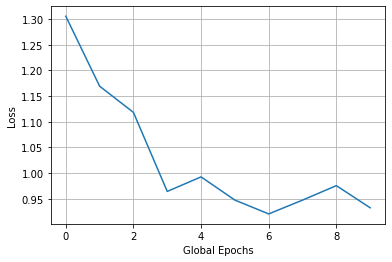

In [102]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.grid()
plt.xlabel('Global Epochs')
plt.ylabel('Loss')
plt.plot(range(len(loss_training)), loss_training)
plt.savefig('first-fed-averaging.png')

In [0]:
def testing_script(global_net, test_loader):
  global_net.eval()
  test_loss, correct = 0, 0
  for indx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = global_net(data)
    test_loss+=F.nll_loss(output, target, reduction='sum').item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

  test_loss/=len(test_loader.dataset)
  accuracy = 100.00*correct/len(test_loader.dataset)
  print('Test Set:  Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(test_loader.dataset),
        accuracy))

In [111]:
testing_script(global_net, test_loader)

Test Set:  Loss: 0.9517, Accuracy: 5960/10000 (60%)
